In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torchvision.transforms as transforms


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print(torch.__version__)

cuda
2.4.1


In [41]:
class CustomDataset(Dataset):
    def __init__(self, image_path_list, label_list):
        self.image_path_list = image_path_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        
        path = self.image_path_list[index]

        frames = self.get_image(path)
            
        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.image_path_list)
    
    def get_image(self, path):
        # Read image
        img = cv2.imread(path)
        if img is None:
            print(f"Error reading image file {path}")
            return torch.empty(0) 
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ''' height, width = img.shape[:2]
        
        if CFG['CROP_SIZE'] > 0 and (width - CFG['CROP_SIZE'] * 2) > 0:
            img = img[:, CFG['CROP_SIZE']:width - CFG['CROP_SIZE']]
        else:
            print(f"Invalid crop size for image {path}")
            return torch.empty(0)
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.0  # Normalize to [0, 1]     '''      
            
        return torch.FloatTensor(img).permute(2, 0, 1)

In [49]:
import torch
import torch.nn as nn

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=6, stride=1):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        self.expanded_channels = in_channels * expansion_factor
        self.conv1 = nn.Conv2d(in_channels, self.expanded_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.expanded_channels)
        self.dwconv = nn.Conv2d(self.expanded_channels, self.expanded_channels, kernel_size=3, stride=stride, padding=1, groups=self.expanded_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(self.expanded_channels)
        self.conv2 = nn.Conv2d(self.expanded_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.skip_connection = nn.Identity() if stride == 1 and in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.silu(out)  # Swish activation
        out = self.dwconv(out)
        out = self.bn2(out)
        out = F.silu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out += identity  # Residual connection
        return out

class EfficientNetResNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetResNet, self).__init__()
        self.conv_stem = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn_stem = nn.BatchNorm2d(32)
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, stride=1),  # Stage 1
            MBConvBlock(16, 24, stride=2),  # Stage 2
            MBConvBlock(24, 40, stride=2),  # Stage 3
            MBConvBlock(40, 80, stride=2),  # Stage 4
            MBConvBlock(80, 112, stride=1), # Stage 5
            MBConvBlock(112, 192, stride=2),# Stage 6
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(192, num_classes)

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn_stem(x)
        x = F.silu(x)
        x = self.blocks(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [64]:
from torchsummary import summary
import torch
model = EfficientNetResNet().to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 16, 112, 112]             512
            Conv2d-4        [-1, 192, 112, 112]           6,144
       BatchNorm2d-5        [-1, 192, 112, 112]             384
            Conv2d-6        [-1, 192, 112, 112]           1,728
       BatchNorm2d-7        [-1, 192, 112, 112]             384
            Conv2d-8         [-1, 16, 112, 112]           3,072
       BatchNorm2d-9         [-1, 16, 112, 112]              32
      MBConvBlock-10         [-1, 16, 112, 112]               0
           Conv2d-11           [-1, 24, 56, 56]             384
           Conv2d-12         [-1, 96, 112, 112]           1,536
      BatchNorm2d-13         [-1, 96, 112, 112]             192
           Conv2d-14           [-1, 96,

In [50]:
def train_model(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = F.cross_entropy
    
    train_losses = []
    val_losses = []
    val_scores = []
    
    best_val_score = 0
    best_model = None
    
    count = 1

    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        
        path = 'weight/1002_' + str(count) + '.pth'
        
        for images, labels in tqdm(iter(train_loader)):
            
            images = images.to(device)
            labels = labels.to(device)
            #print("real : ", labels)
            
            optimizer.zero_grad()
            
            output = model(images)
            
            main_loss = criterion(output.float(), labels.long())
            
            total_loss = main_loss
            
            total_loss.backward()
            optimizer.step()
            
            train_loss.append(total_loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        train_losses.append(_train_loss)
        val_losses.append(_val_loss)
        val_scores.append(_val_score)
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            

        # torch.save(model.state_dict(), path)
        count = count + 1
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses')
    plt.legend()
    
    #plt.savefig('./4. Loss/0320_epoch20.png')
    
    plt.show()
    
    return best_model

In [51]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            logit = model(videos)
            
            loss = criterion(logit.float(), labels.long())
            #print(loss)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

In [52]:
def inference(model, test_loader, device):
    count = 1
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)
            logit = model(images)
            #print(count)
            #print(logit)
            #print()
            count = count + 1
            #print("logit: ",logit)
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            #print("preds: ",preds)

            #print()
            
            
    return preds

In [53]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':41,
    'CROP_SIZE':200
}

In [56]:
def train_n_infer(case_num):
    case_name = f"Case_{case_num}"
    print(f"{case_name} 처리 중...")

    # CSV 파일 불러오기
    train = pd.read_csv(f"/media/wkdtjdqls/easymean_1/Protocol_Data/{case_name}/TRAIN.csv")
    val = pd.read_csv(f"/media/wkdtjdqls/easymean_1/Protocol_Data/{case_name}/VAL.csv")
    test = pd.read_csv(f"/media/wkdtjdqls/easymean_1/Protocol_Data/{case_name}/TEST.csv")

    # 데이터 로더 설정
    train_dataset = CustomDataset(train['path'].values, train['label'].values)
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
    val_dataset = CustomDataset(val['path'].values, val['label'].values)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
    test_dataset = CustomDataset(test['path'].values, None)
    test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    # 모델 및 최적화 설정
    model = EfficientNetResNet().to(device)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)


    # 모델 학습
    infer_model = train_model(model, optimizer, train_loader, val_loader, scheduler, device)

    # 학습된 모델 저장
    torch.save(infer_model.state_dict(), f"/home/wkdtjdqls/jsb_ws/network/07. cnn/re/weight/effi_res/{case_name}_model.pth")
    print(f"{case_name} 학습 완료 및 모델 저장")

Case_1 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.55197] Val Loss : [0.78050] Val F1 : [0.75623]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20008] Val Loss : [0.47643] Val F1 : [0.82208]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15446] Val Loss : [0.26684] Val F1 : [0.89894]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13300] Val Loss : [0.22626] Val F1 : [0.93392]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12266] Val Loss : [0.24157] Val F1 : [0.90633]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11341] Val Loss : [0.29314] Val F1 : [0.91464]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10756] Val Loss : [0.22128] Val F1 : [0.92178]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08902] Val Loss : [0.21004] Val F1 : [0.92968]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08556] Val Loss : [0.17913] Val F1 : [0.92880]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08209] Val Loss : [0.22279] Val F1 : [0.92713]


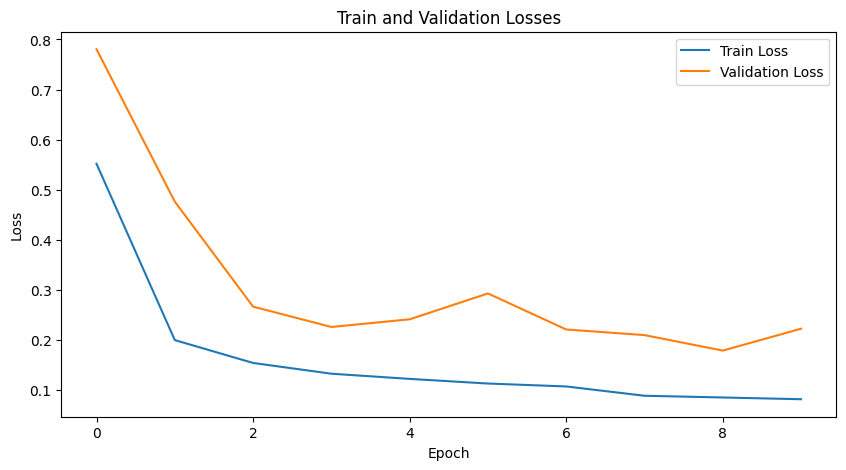

Case_1 학습 완료 및 모델 저장
Case_2 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.50549] Val Loss : [0.64349] Val F1 : [0.71829]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20034] Val Loss : [0.32066] Val F1 : [0.88190]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15138] Val Loss : [0.31414] Val F1 : [0.88929]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13108] Val Loss : [0.24346] Val F1 : [0.91325]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12057] Val Loss : [0.24680] Val F1 : [0.92035]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11131] Val Loss : [0.20112] Val F1 : [0.93183]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10479] Val Loss : [0.19413] Val F1 : [0.92963]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09888] Val Loss : [0.17850] Val F1 : [0.93428]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09633] Val Loss : [0.20463] Val F1 : [0.93260]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09301] Val Loss : [0.19484] Val F1 : [0.92363]


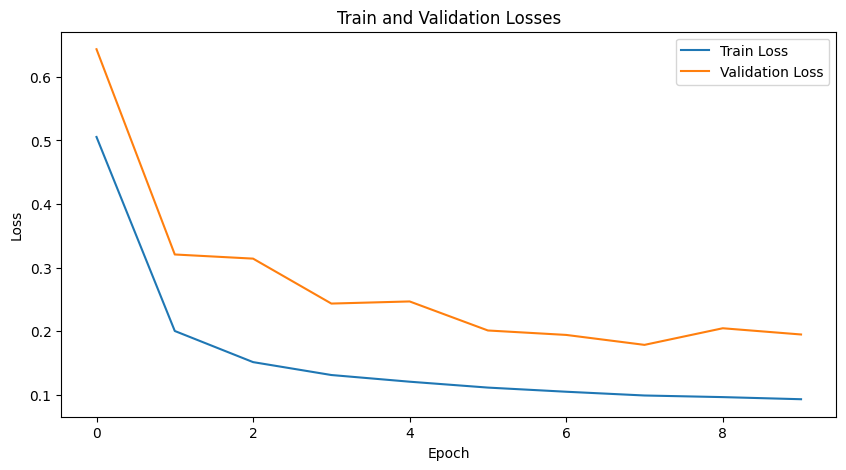

Case_2 학습 완료 및 모델 저장
Case_3 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.62541] Val Loss : [0.72290] Val F1 : [0.69626]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.24789] Val Loss : [0.52122] Val F1 : [0.80910]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17232] Val Loss : [0.28480] Val F1 : [0.90049]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14139] Val Loss : [0.24275] Val F1 : [0.91981]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12576] Val Loss : [0.20886] Val F1 : [0.91635]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11610] Val Loss : [0.33688] Val F1 : [0.89297]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11063] Val Loss : [0.30474] Val F1 : [0.90976]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09185] Val Loss : [0.24088] Val F1 : [0.92988]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08581] Val Loss : [0.21397] Val F1 : [0.92558]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08321] Val Loss : [0.25298] Val F1 : [0.92150]


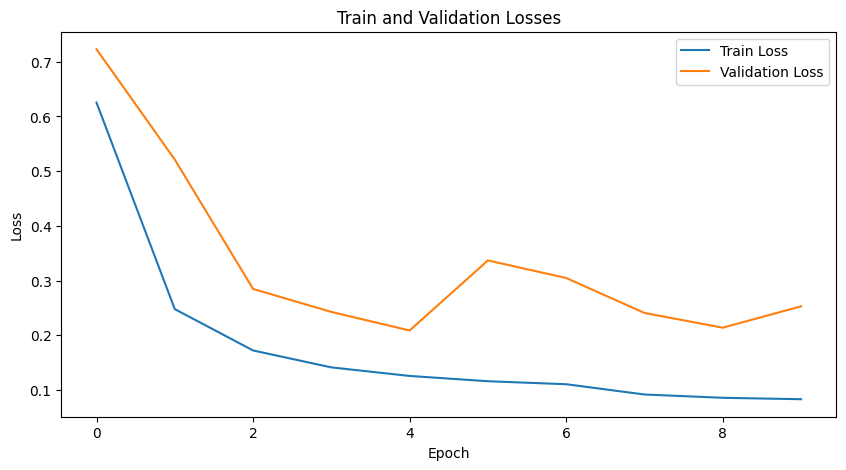

Case_3 학습 완료 및 모델 저장
Case_4 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.57642] Val Loss : [0.59786] Val F1 : [0.76057]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22892] Val Loss : [0.56762] Val F1 : [0.78356]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16623] Val Loss : [0.37102] Val F1 : [0.86588]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14682] Val Loss : [0.23663] Val F1 : [0.92598]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12904] Val Loss : [0.21525] Val F1 : [0.92095]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11849] Val Loss : [0.27050] Val F1 : [0.90913]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11392] Val Loss : [0.27667] Val F1 : [0.90571]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09238] Val Loss : [0.19449] Val F1 : [0.93275]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08815] Val Loss : [0.20044] Val F1 : [0.92574]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08427] Val Loss : [0.21327] Val F1 : [0.92582]


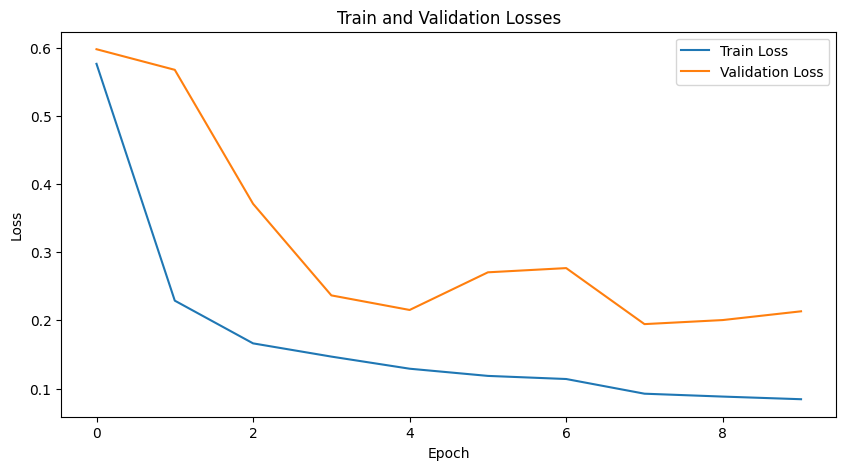

Case_4 학습 완료 및 모델 저장
Case_5 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.54156] Val Loss : [0.73875] Val F1 : [0.70098]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.23119] Val Loss : [0.34339] Val F1 : [0.86477]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16607] Val Loss : [0.25524] Val F1 : [0.89260]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14301] Val Loss : [0.38209] Val F1 : [0.85117]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12905] Val Loss : [0.26036] Val F1 : [0.89669]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12048] Val Loss : [0.21754] Val F1 : [0.91765]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11258] Val Loss : [0.23653] Val F1 : [0.91799]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10625] Val Loss : [0.21161] Val F1 : [0.92524]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10388] Val Loss : [0.22113] Val F1 : [0.93022]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09833] Val Loss : [0.27189] Val F1 : [0.91222]


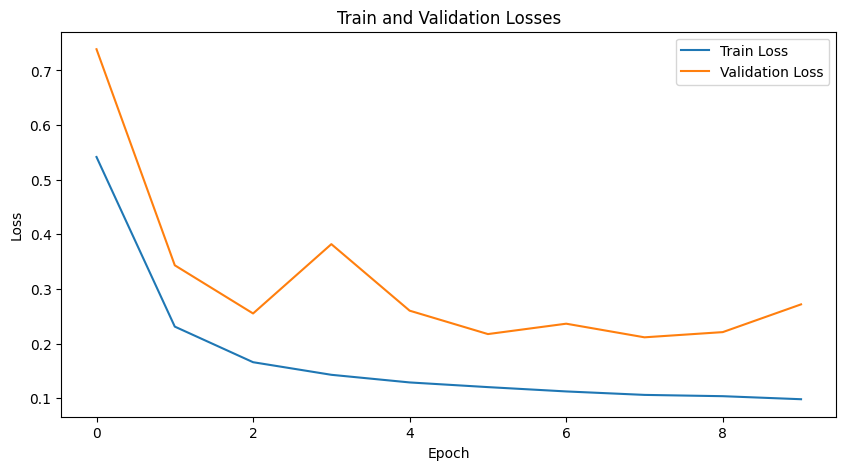

Case_5 학습 완료 및 모델 저장
Case_6 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.50163] Val Loss : [0.71471] Val F1 : [0.74955]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20863] Val Loss : [0.45822] Val F1 : [0.83195]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15739] Val Loss : [0.30330] Val F1 : [0.86369]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13584] Val Loss : [0.35075] Val F1 : [0.87116]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12303] Val Loss : [0.36078] Val F1 : [0.88364]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11435] Val Loss : [0.23229] Val F1 : [0.91362]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10897] Val Loss : [0.23549] Val F1 : [0.90493]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10268] Val Loss : [0.19645] Val F1 : [0.92811]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09920] Val Loss : [0.23007] Val F1 : [0.91938]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09538] Val Loss : [0.19841] Val F1 : [0.92694]


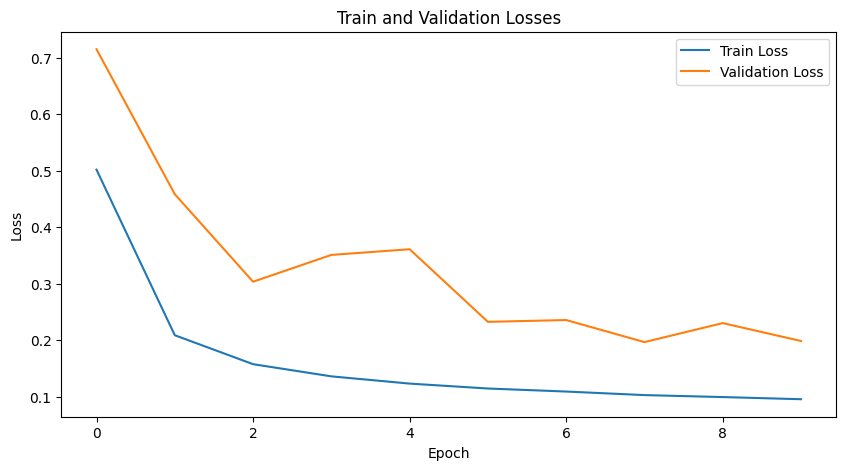

Case_6 학습 완료 및 모델 저장
Case_7 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.48984] Val Loss : [0.94075] Val F1 : [0.65147]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20001] Val Loss : [0.51195] Val F1 : [0.82961]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15702] Val Loss : [0.47827] Val F1 : [0.83537]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13591] Val Loss : [0.27633] Val F1 : [0.91879]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12340] Val Loss : [0.29387] Val F1 : [0.90583]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11562] Val Loss : [0.27040] Val F1 : [0.90840]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10918] Val Loss : [0.30727] Val F1 : [0.89780]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09174] Val Loss : [0.17390] Val F1 : [0.93894]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08687] Val Loss : [0.22809] Val F1 : [0.91061]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08531] Val Loss : [0.32627] Val F1 : [0.89417]


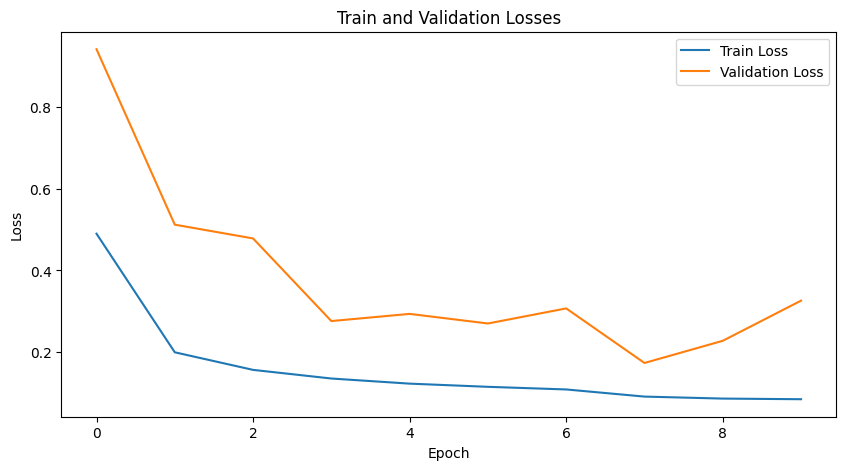

Case_7 학습 완료 및 모델 저장
Case_8 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.63194] Val Loss : [0.72289] Val F1 : [0.71047]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.27014] Val Loss : [0.35714] Val F1 : [0.87029]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17659] Val Loss : [0.23708] Val F1 : [0.91836]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14492] Val Loss : [0.25311] Val F1 : [0.92270]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.13065] Val Loss : [0.39689] Val F1 : [0.84929]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12031] Val Loss : [0.17616] Val F1 : [0.93881]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11276] Val Loss : [0.24433] Val F1 : [0.92269]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10669] Val Loss : [0.18893] Val F1 : [0.94075]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10355] Val Loss : [0.19399] Val F1 : [0.94355]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09807] Val Loss : [0.15859] Val F1 : [0.95031]


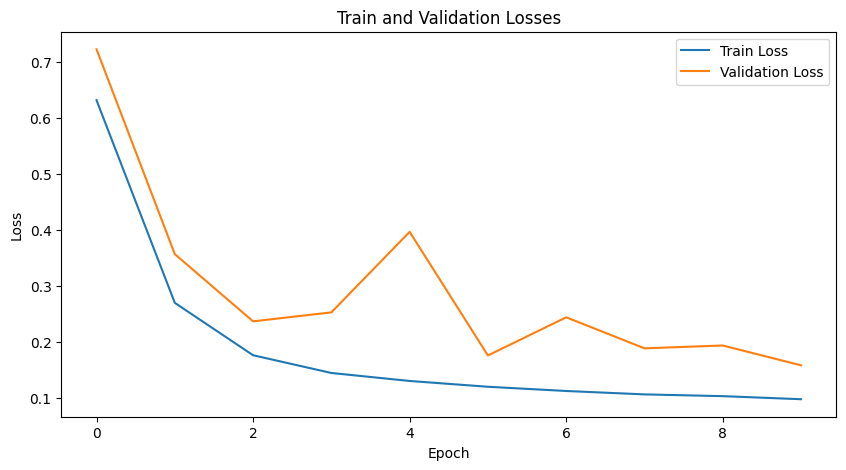

Case_8 학습 완료 및 모델 저장
Case_9 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.54973] Val Loss : [0.86656] Val F1 : [0.67470]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22781] Val Loss : [0.64430] Val F1 : [0.78266]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16266] Val Loss : [0.32382] Val F1 : [0.88985]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13924] Val Loss : [0.31431] Val F1 : [0.89139]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12690] Val Loss : [0.21373] Val F1 : [0.91715]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11867] Val Loss : [0.26555] Val F1 : [0.90870]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10964] Val Loss : [0.23586] Val F1 : [0.91357]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10505] Val Loss : [0.29976] Val F1 : [0.89069]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08897] Val Loss : [0.23405] Val F1 : [0.92079]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08501] Val Loss : [0.21060] Val F1 : [0.92250]


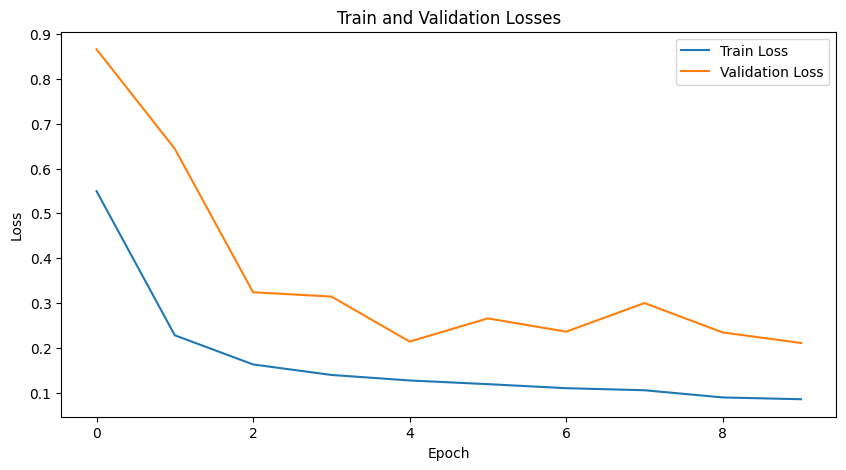

Case_9 학습 완료 및 모델 저장
Case_10 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.53427] Val Loss : [0.66308] Val F1 : [0.74224]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.21322] Val Loss : [0.34367] Val F1 : [0.88269]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15577] Val Loss : [0.30306] Val F1 : [0.88596]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13409] Val Loss : [0.26382] Val F1 : [0.90927]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12112] Val Loss : [0.25603] Val F1 : [0.92748]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11220] Val Loss : [0.28219] Val F1 : [0.90195]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10824] Val Loss : [0.17767] Val F1 : [0.93628]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10250] Val Loss : [0.19634] Val F1 : [0.93224]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09780] Val Loss : [0.29352] Val F1 : [0.88078]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09413] Val Loss : [0.16530] Val F1 : [0.94729]


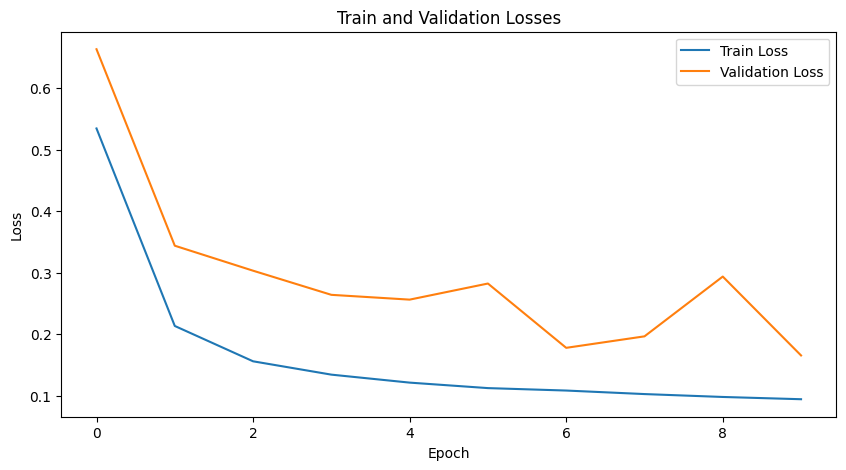

Case_10 학습 완료 및 모델 저장
Case_11 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60245] Val Loss : [0.83450] Val F1 : [0.61165]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.26176] Val Loss : [0.37773] Val F1 : [0.84827]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17549] Val Loss : [0.27847] Val F1 : [0.89981]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14321] Val Loss : [0.26903] Val F1 : [0.90683]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.13002] Val Loss : [0.23733] Val F1 : [0.90807]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12097] Val Loss : [0.25280] Val F1 : [0.91881]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11269] Val Loss : [0.19000] Val F1 : [0.93189]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10735] Val Loss : [0.21083] Val F1 : [0.91895]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10151] Val Loss : [0.23752] Val F1 : [0.91710]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.10108] Val Loss : [0.26223] Val F1 : [0.90095]


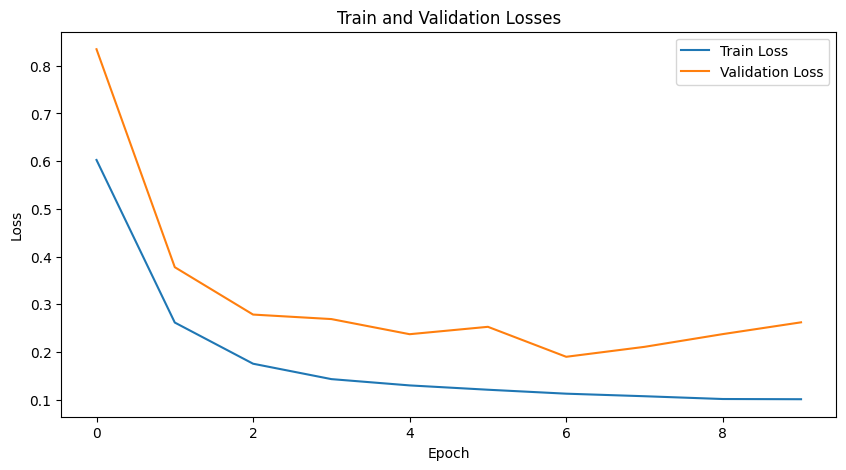

Case_11 학습 완료 및 모델 저장
Case_12 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.49866] Val Loss : [0.60977] Val F1 : [0.78032]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22180] Val Loss : [0.44059] Val F1 : [0.85670]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15767] Val Loss : [0.35312] Val F1 : [0.88237]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13527] Val Loss : [0.23995] Val F1 : [0.91561]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12228] Val Loss : [0.22049] Val F1 : [0.94187]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11235] Val Loss : [0.18379] Val F1 : [0.93383]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10613] Val Loss : [0.26180] Val F1 : [0.90881]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10125] Val Loss : [0.22649] Val F1 : [0.92259]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08479] Val Loss : [0.15873] Val F1 : [0.93996]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08091] Val Loss : [0.14838] Val F1 : [0.94273]


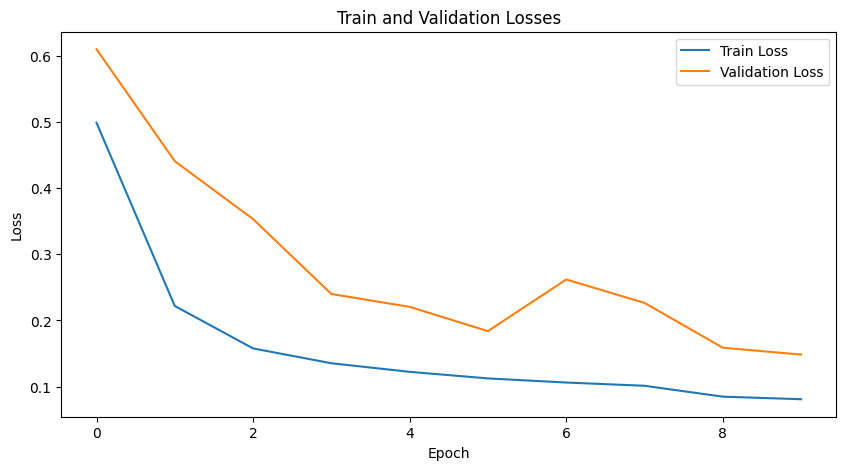

Case_12 학습 완료 및 모델 저장
Case_13 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.54334] Val Loss : [0.57932] Val F1 : [0.74308]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20427] Val Loss : [0.34265] Val F1 : [0.88156]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15313] Val Loss : [0.28536] Val F1 : [0.88924]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13214] Val Loss : [0.17550] Val F1 : [0.92752]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12096] Val Loss : [0.16610] Val F1 : [0.93978]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11098] Val Loss : [0.21483] Val F1 : [0.92851]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10570] Val Loss : [0.20389] Val F1 : [0.92204]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10179] Val Loss : [0.16737] Val F1 : [0.94537]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09760] Val Loss : [0.18908] Val F1 : [0.92761]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09446] Val Loss : [0.14947] Val F1 : [0.94196]


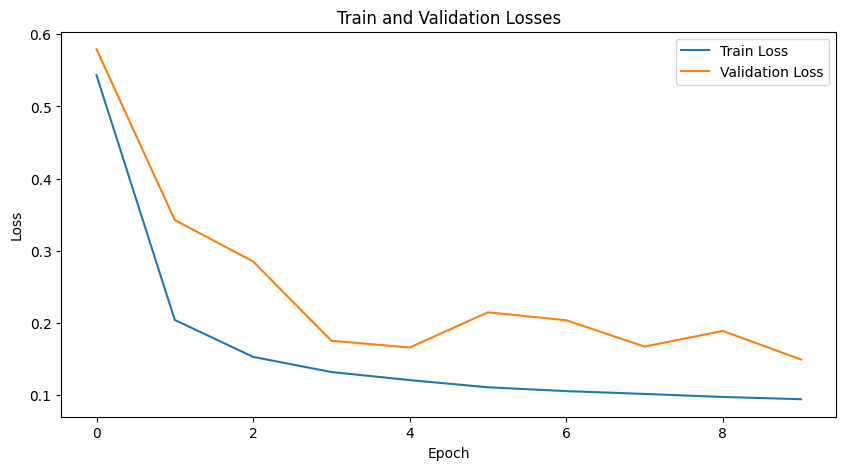

Case_13 학습 완료 및 모델 저장
Case_14 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.50216] Val Loss : [0.58710] Val F1 : [0.74261]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20936] Val Loss : [0.30292] Val F1 : [0.89197]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16240] Val Loss : [0.31602] Val F1 : [0.89498]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13881] Val Loss : [0.26676] Val F1 : [0.91177]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12711] Val Loss : [0.21534] Val F1 : [0.92954]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11572] Val Loss : [0.23702] Val F1 : [0.90148]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11116] Val Loss : [0.24800] Val F1 : [0.91649]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10636] Val Loss : [0.20036] Val F1 : [0.92811]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08917] Val Loss : [0.20961] Val F1 : [0.92248]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08388] Val Loss : [0.21662] Val F1 : [0.91268]


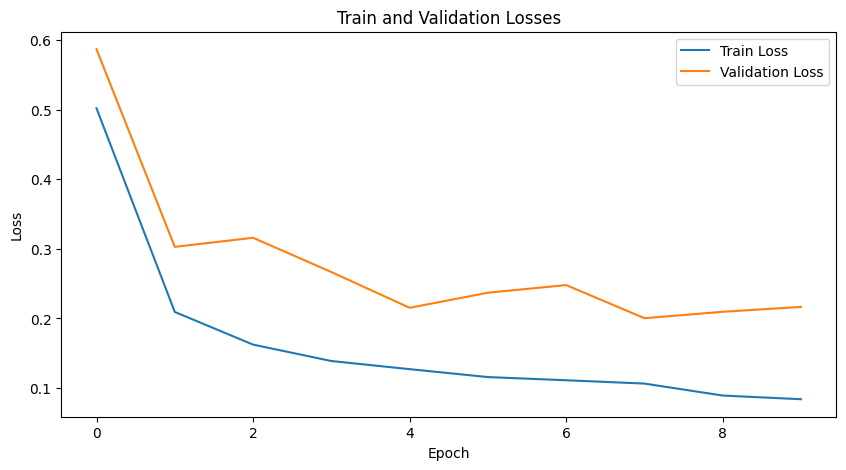

Case_14 학습 완료 및 모델 저장
Case_15 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60379] Val Loss : [0.79059] Val F1 : [0.65704]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.23826] Val Loss : [0.41155] Val F1 : [0.84969]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16230] Val Loss : [0.30747] Val F1 : [0.89462]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13530] Val Loss : [0.17830] Val F1 : [0.93301]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12237] Val Loss : [0.24980] Val F1 : [0.90436]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11227] Val Loss : [0.20189] Val F1 : [0.93262]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10580] Val Loss : [0.17366] Val F1 : [0.94292]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10098] Val Loss : [0.18660] Val F1 : [0.93762]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09722] Val Loss : [0.18354] Val F1 : [0.94162]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09212] Val Loss : [0.16255] Val F1 : [0.94309]


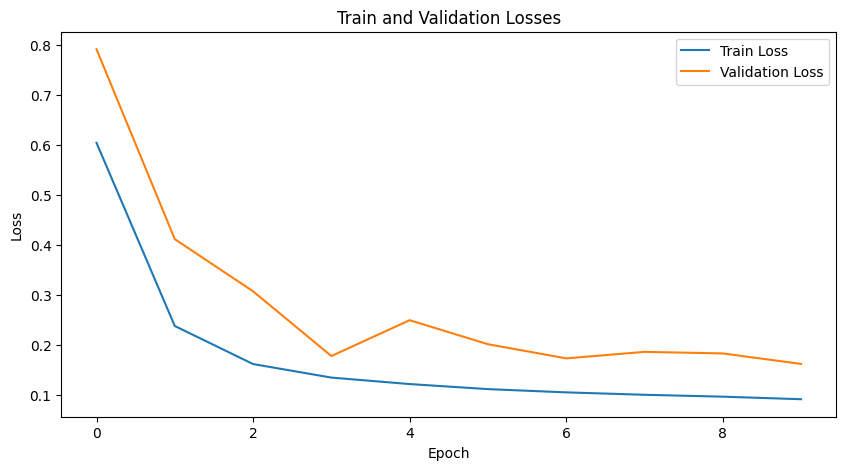

Case_15 학습 완료 및 모델 저장
Case_16 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.51041] Val Loss : [0.52006] Val F1 : [0.81287]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20032] Val Loss : [0.35025] Val F1 : [0.88252]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15312] Val Loss : [0.27800] Val F1 : [0.90960]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13230] Val Loss : [0.24796] Val F1 : [0.92262]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12237] Val Loss : [0.27209] Val F1 : [0.89712]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11402] Val Loss : [0.26361] Val F1 : [0.91854]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10583] Val Loss : [0.18867] Val F1 : [0.93180]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10104] Val Loss : [0.23456] Val F1 : [0.93060]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09742] Val Loss : [0.23100] Val F1 : [0.93318]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09353] Val Loss : [0.19382] Val F1 : [0.92686]


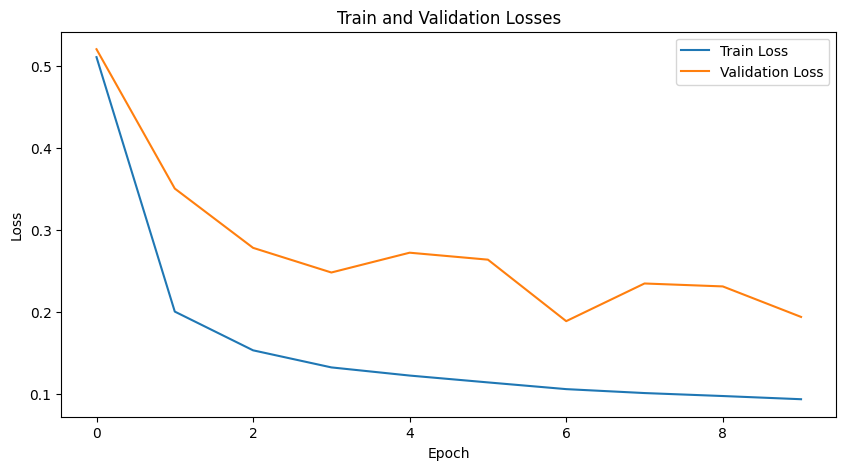

Case_16 학습 완료 및 모델 저장
Case_17 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.53159] Val Loss : [0.67839] Val F1 : [0.73487]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.21691] Val Loss : [0.33792] Val F1 : [0.88105]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15535] Val Loss : [0.30774] Val F1 : [0.89615]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13469] Val Loss : [0.30616] Val F1 : [0.89809]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12194] Val Loss : [0.25720] Val F1 : [0.92603]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11280] Val Loss : [0.19531] Val F1 : [0.93951]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10720] Val Loss : [0.24235] Val F1 : [0.92681]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10076] Val Loss : [0.25774] Val F1 : [0.91398]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09664] Val Loss : [0.25559] Val F1 : [0.91748]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08066] Val Loss : [0.17983] Val F1 : [0.94495]


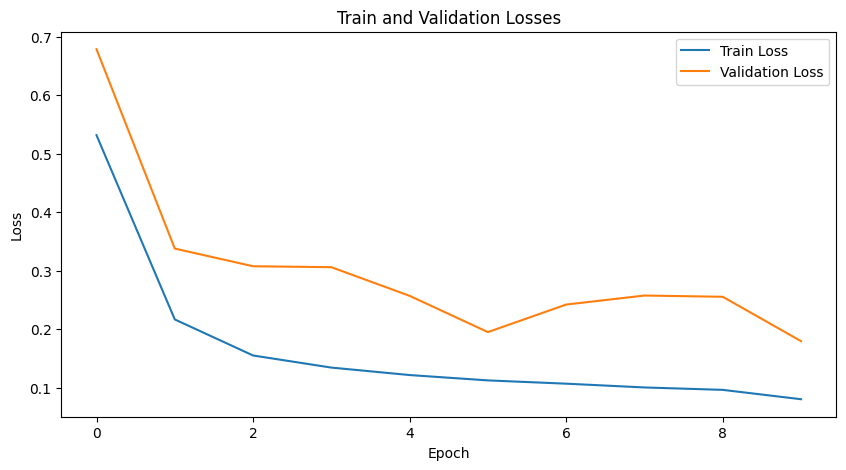

Case_17 학습 완료 및 모델 저장
Case_18 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.66274] Val Loss : [0.82787] Val F1 : [0.65906]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.28945] Val Loss : [0.45638] Val F1 : [0.84085]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17663] Val Loss : [0.38599] Val F1 : [0.86864]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14428] Val Loss : [0.34013] Val F1 : [0.88307]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12845] Val Loss : [0.27023] Val F1 : [0.90260]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11900] Val Loss : [0.37616] Val F1 : [0.87315]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10984] Val Loss : [0.28824] Val F1 : [0.91844]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10513] Val Loss : [0.28952] Val F1 : [0.90123]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10022] Val Loss : [0.26304] Val F1 : [0.90657]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09774] Val Loss : [0.29477] Val F1 : [0.90327]


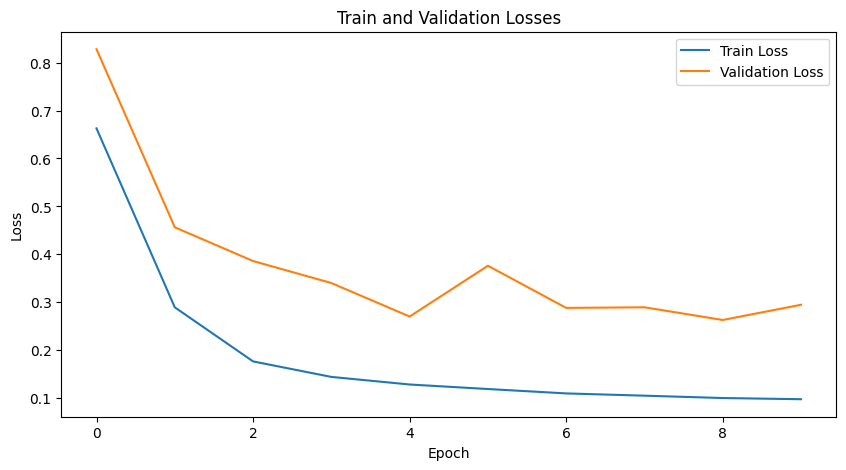

Case_18 학습 완료 및 모델 저장
Case_19 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.63743] Val Loss : [0.95460] Val F1 : [0.58182]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.26790] Val Loss : [0.44733] Val F1 : [0.83702]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17387] Val Loss : [0.44755] Val F1 : [0.85157]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14291] Val Loss : [0.30503] Val F1 : [0.88345]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12659] Val Loss : [0.31337] Val F1 : [0.89308]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11712] Val Loss : [0.24728] Val F1 : [0.91085]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11059] Val Loss : [0.21576] Val F1 : [0.92600]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10767] Val Loss : [0.24935] Val F1 : [0.92095]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10265] Val Loss : [0.26444] Val F1 : [0.91575]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09831] Val Loss : [0.29297] Val F1 : [0.90511]


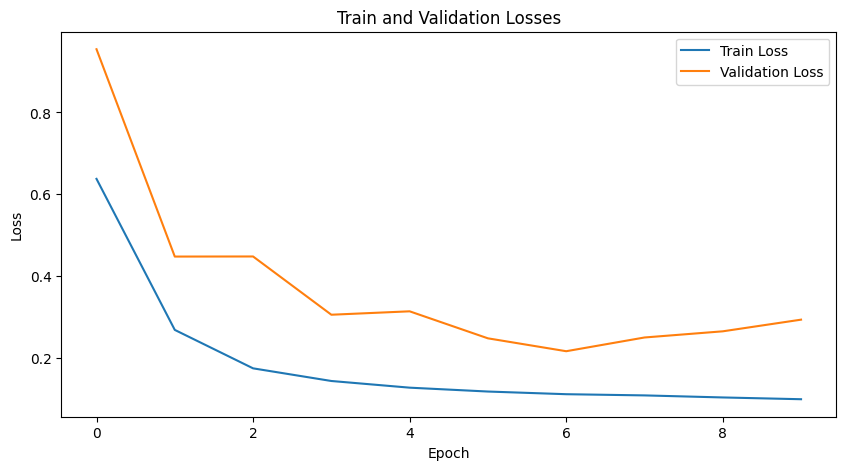

Case_19 학습 완료 및 모델 저장
Case_20 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.51265] Val Loss : [0.54927] Val F1 : [0.76805]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20620] Val Loss : [0.33845] Val F1 : [0.87385]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15112] Val Loss : [0.23958] Val F1 : [0.90778]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.12950] Val Loss : [0.23872] Val F1 : [0.92011]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.11921] Val Loss : [0.30204] Val F1 : [0.89033]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.10976] Val Loss : [0.20761] Val F1 : [0.92632]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10401] Val Loss : [0.17495] Val F1 : [0.93438]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.09928] Val Loss : [0.18059] Val F1 : [0.92684]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09555] Val Loss : [0.20098] Val F1 : [0.92317]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09212] Val Loss : [0.17739] Val F1 : [0.92429]


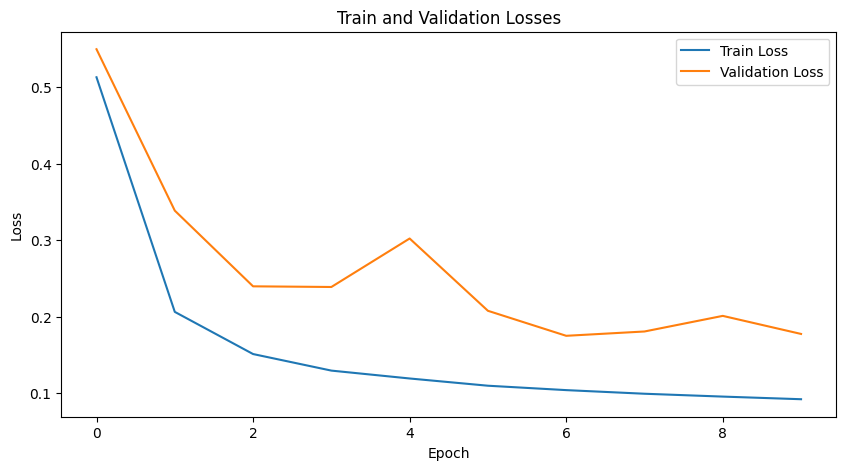

Case_20 학습 완료 및 모델 저장
Case_21 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.50158] Val Loss : [0.62433] Val F1 : [0.75831]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20179] Val Loss : [0.29396] Val F1 : [0.89581]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15167] Val Loss : [0.26892] Val F1 : [0.89116]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13505] Val Loss : [0.26955] Val F1 : [0.90175]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12191] Val Loss : [0.20161] Val F1 : [0.92232]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11412] Val Loss : [0.16962] Val F1 : [0.93634]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10737] Val Loss : [0.21691] Val F1 : [0.90966]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10201] Val Loss : [0.13230] Val F1 : [0.93885]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09750] Val Loss : [0.16214] Val F1 : [0.92833]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09515] Val Loss : [0.18619] Val F1 : [0.92191]


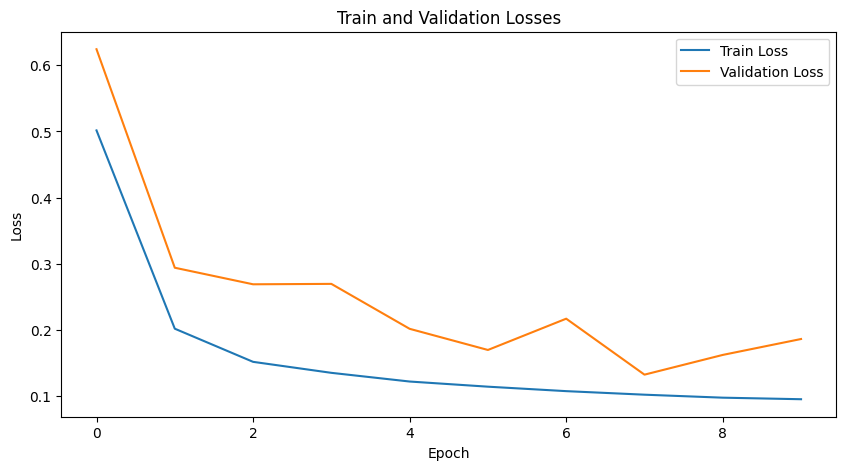

Case_21 학습 완료 및 모델 저장
Case_22 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60897] Val Loss : [0.78143] Val F1 : [0.70034]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.23066] Val Loss : [0.37790] Val F1 : [0.86309]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16320] Val Loss : [0.32109] Val F1 : [0.90474]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13907] Val Loss : [0.23646] Val F1 : [0.91083]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12644] Val Loss : [0.24256] Val F1 : [0.92385]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11671] Val Loss : [0.32357] Val F1 : [0.87842]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11083] Val Loss : [0.25141] Val F1 : [0.91292]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10529] Val Loss : [0.20505] Val F1 : [0.92559]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09971] Val Loss : [0.21216] Val F1 : [0.93171]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09712] Val Loss : [0.27757] Val F1 : [0.91738]


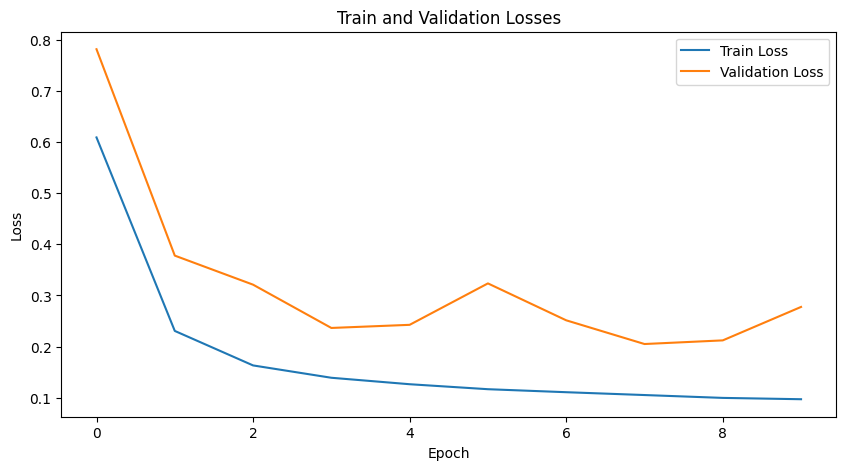

Case_22 학습 완료 및 모델 저장
Case_23 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60011] Val Loss : [0.85651] Val F1 : [0.65642]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22372] Val Loss : [0.36625] Val F1 : [0.85982]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15902] Val Loss : [0.26590] Val F1 : [0.91106]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13734] Val Loss : [0.23030] Val F1 : [0.91294]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12417] Val Loss : [0.21497] Val F1 : [0.92689]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11586] Val Loss : [0.18207] Val F1 : [0.93839]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10884] Val Loss : [0.22612] Val F1 : [0.91068]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10402] Val Loss : [0.23300] Val F1 : [0.91339]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09964] Val Loss : [0.17806] Val F1 : [0.94378]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09420] Val Loss : [0.16739] Val F1 : [0.93789]


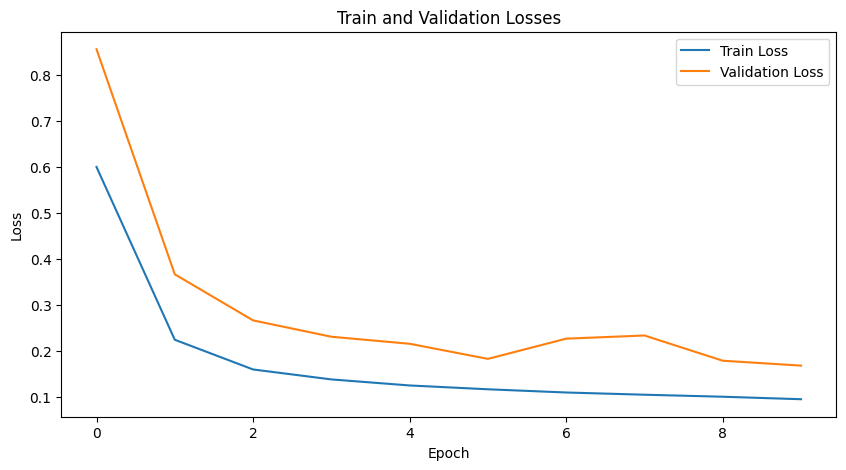

Case_23 학습 완료 및 모델 저장
Case_24 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.53383] Val Loss : [0.73653] Val F1 : [0.73395]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.21806] Val Loss : [0.48557] Val F1 : [0.81842]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15888] Val Loss : [0.53546] Val F1 : [0.84043]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13702] Val Loss : [0.32807] Val F1 : [0.89397]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12391] Val Loss : [0.28486] Val F1 : [0.89802]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11543] Val Loss : [0.28472] Val F1 : [0.89539]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10847] Val Loss : [0.29865] Val F1 : [0.92465]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10405] Val Loss : [0.23714] Val F1 : [0.92394]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09938] Val Loss : [0.24565] Val F1 : [0.92229]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09550] Val Loss : [0.21953] Val F1 : [0.92635]


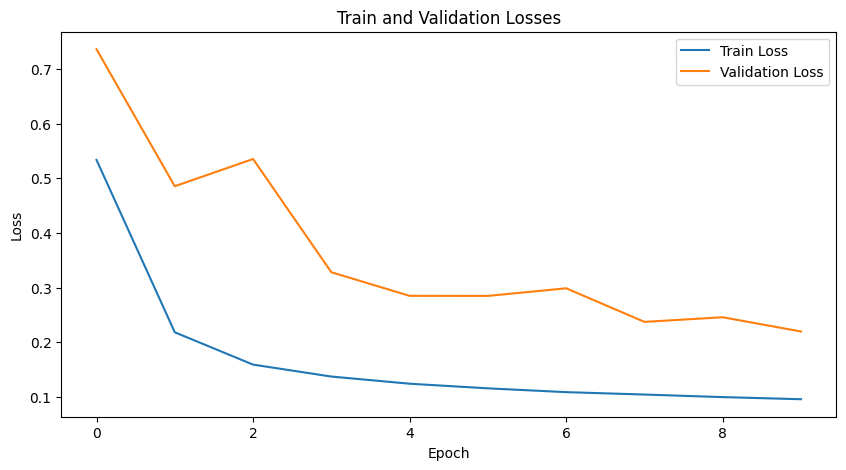

Case_24 학습 완료 및 모델 저장
Case_25 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.52618] Val Loss : [0.69859] Val F1 : [0.71611]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22204] Val Loss : [0.42031] Val F1 : [0.87190]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16203] Val Loss : [0.38191] Val F1 : [0.87535]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13696] Val Loss : [0.40413] Val F1 : [0.85835]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12253] Val Loss : [0.27488] Val F1 : [0.90893]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11479] Val Loss : [0.25267] Val F1 : [0.89533]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10655] Val Loss : [0.27710] Val F1 : [0.89913]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10235] Val Loss : [0.29780] Val F1 : [0.87900]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08601] Val Loss : [0.15096] Val F1 : [0.93257]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08186] Val Loss : [0.22305] Val F1 : [0.92150]


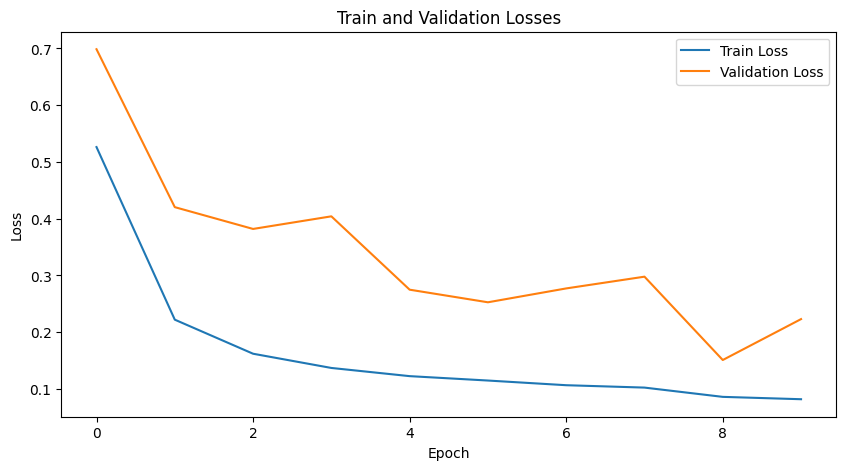

Case_25 학습 완료 및 모델 저장
Case_26 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.58283] Val Loss : [0.64083] Val F1 : [0.74305]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.23321] Val Loss : [0.36861] Val F1 : [0.84483]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16033] Val Loss : [0.33594] Val F1 : [0.86619]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13604] Val Loss : [0.21658] Val F1 : [0.92312]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12429] Val Loss : [0.17850] Val F1 : [0.93031]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11480] Val Loss : [0.21365] Val F1 : [0.91402]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10875] Val Loss : [0.20939] Val F1 : [0.93001]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10308] Val Loss : [0.22802] Val F1 : [0.92782]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.08733] Val Loss : [0.25581] Val F1 : [0.90966]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.08278] Val Loss : [0.19551] Val F1 : [0.92987]


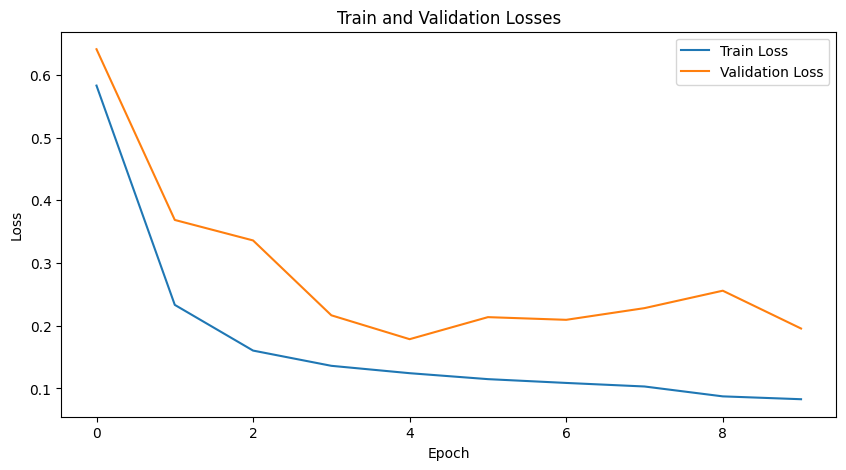

Case_26 학습 완료 및 모델 저장
Case_27 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.51500] Val Loss : [0.62775] Val F1 : [0.78815]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.20034] Val Loss : [0.43328] Val F1 : [0.84086]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15169] Val Loss : [0.25858] Val F1 : [0.90700]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.13288] Val Loss : [0.30309] Val F1 : [0.88959]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12173] Val Loss : [0.21958] Val F1 : [0.91792]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11486] Val Loss : [0.25916] Val F1 : [0.91652]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10784] Val Loss : [0.13660] Val F1 : [0.94691]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10340] Val Loss : [0.18786] Val F1 : [0.93285]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09897] Val Loss : [0.15726] Val F1 : [0.93587]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09577] Val Loss : [0.18512] Val F1 : [0.92762]


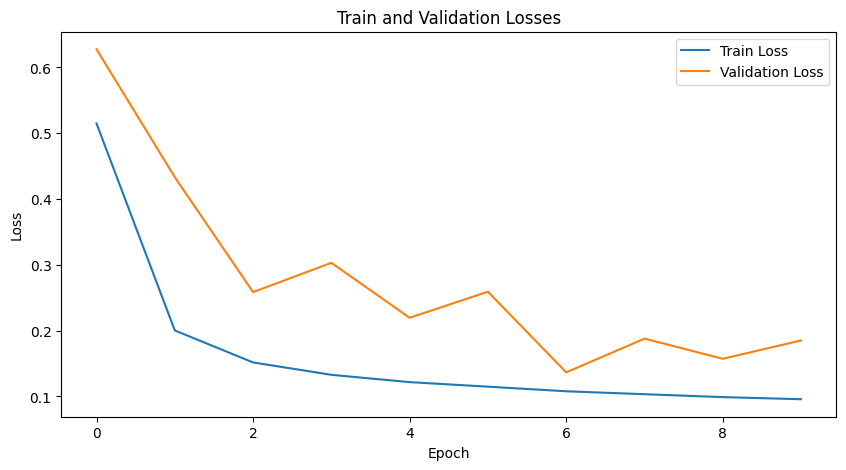

Case_27 학습 완료 및 모델 저장
Case_28 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60553] Val Loss : [0.85695] Val F1 : [0.71045]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22279] Val Loss : [0.28808] Val F1 : [0.89348]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16145] Val Loss : [0.33782] Val F1 : [0.88818]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14218] Val Loss : [0.30917] Val F1 : [0.89783]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12667] Val Loss : [0.31901] Val F1 : [0.88947]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11633] Val Loss : [0.22050] Val F1 : [0.91393]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10946] Val Loss : [0.26330] Val F1 : [0.90073]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10434] Val Loss : [0.22051] Val F1 : [0.92841]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09949] Val Loss : [0.20351] Val F1 : [0.93627]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09652] Val Loss : [0.23383] Val F1 : [0.92362]


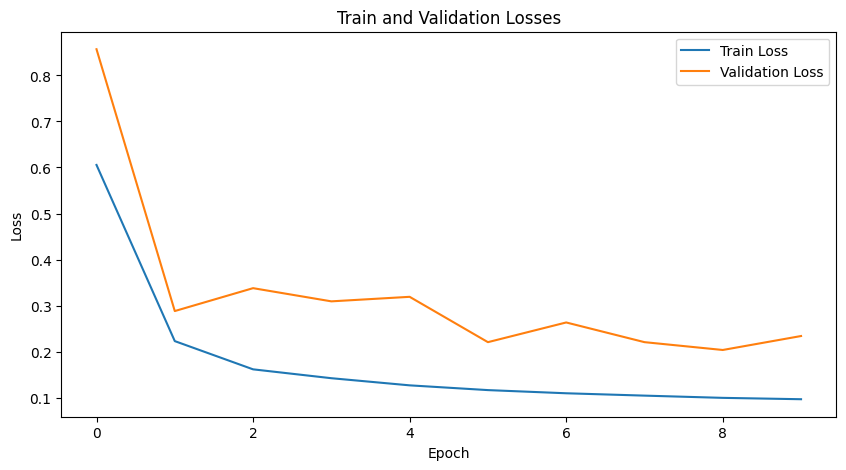

Case_28 학습 완료 및 모델 저장
Case_29 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.48945] Val Loss : [0.58594] Val F1 : [0.79537]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.18908] Val Loss : [0.42877] Val F1 : [0.87263]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.14807] Val Loss : [0.32155] Val F1 : [0.89635]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.12936] Val Loss : [0.26377] Val F1 : [0.91077]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.11994] Val Loss : [0.26558] Val F1 : [0.90018]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11191] Val Loss : [0.39760] Val F1 : [0.85220]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10504] Val Loss : [0.26928] Val F1 : [0.91715]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10068] Val Loss : [0.23502] Val F1 : [0.92201]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09762] Val Loss : [0.22898] Val F1 : [0.92553]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09335] Val Loss : [0.24125] Val F1 : [0.92591]


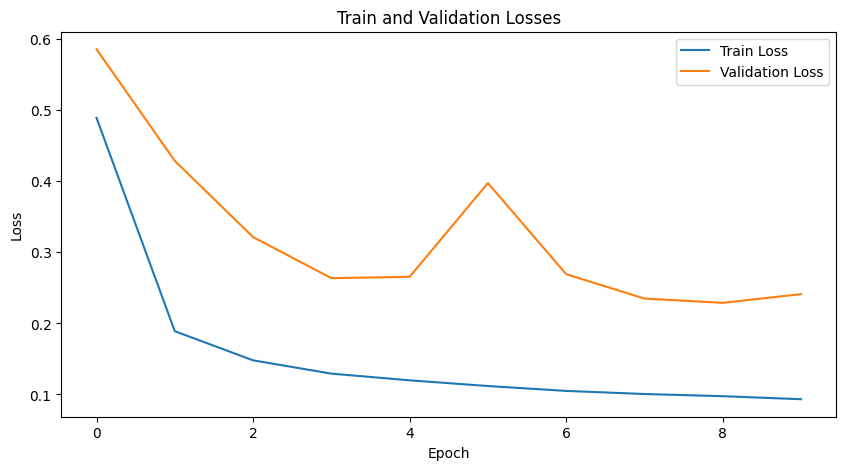

Case_29 학습 완료 및 모델 저장
Case_30 처리 중...


/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.60185] Val Loss : [0.86915] Val F1 : [0.65989]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.24869] Val Loss : [0.33968] Val F1 : [0.87347]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16727] Val Loss : [0.29798] Val F1 : [0.91546]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.14180] Val Loss : [0.29151] Val F1 : [0.91279]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.12686] Val Loss : [0.25211] Val F1 : [0.92240]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.11873] Val Loss : [0.24298] Val F1 : [0.92270]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.11210] Val Loss : [0.20715] Val F1 : [0.92592]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.10661] Val Loss : [0.23723] Val F1 : [0.91802]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.10036] Val Loss : [0.16407] Val F1 : [0.94457]


  0%|          | 0/18435 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.09740] Val Loss : [0.20399] Val F1 : [0.93203]


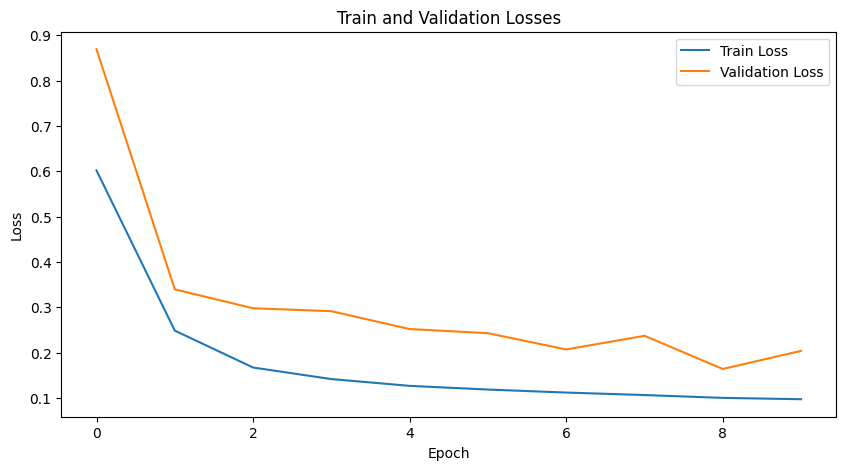

Case_30 학습 완료 및 모델 저장


In [57]:
for i in range(1, 31):
    train_n_infer(i)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader


# case 결과 저장용 리스트 초기화
results = []
# 모든 케이스의 프로토콜별 결과를 저장할 리스트 초기화
all_case_results = []

def test_and_visualize(case_num):
    case_name = f"Case_{case_num}"
    print(f"{case_name} 처리 중...")

    # 모델 초기화 및 가중치 로드
    model = EfficientNetResNet().to(device)
    weight_path = f"/home/wkdtjdqls/jsb_ws/network/07. cnn/re/weight/effi_res/Case_{case_num}_model.pth"
    model.load_state_dict(torch.load(weight_path))

    # CSV 파일 불러오기
    test_data = pd.read_csv(f"/media/wkdtjdqls/easymean_1/Protocol_Data/{case_name}/TEST.csv")

    # 데이터 로더 설정
    test_dataset = CustomDataset(test_data['path'].values, None)
    test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    # 모델 추론
    preds = inference(model, test_loader, device)
    
    # 테스트 레이블과 비교
    test_result = test_data['label']

    # 메트릭 계산
    score_acc = accuracy_score(test_result, preds)
    score_f1 = f1_score(test_result, preds, average='weighted')
    score_precision = precision_score(test_result, preds, average='weighted')

    print(f"Accuracy: {score_acc:.4f}, F1 Score: {score_f1:.4f}, Precision: {score_precision:.4f}")

    # case마다의 결과 저장
    results.append({
        'Case': case_name,
        'Accuracy': score_acc,
        'F1_Score': score_f1,
        'Precision': score_precision
    })

    # 테스트 결과 비교
    preds = np.array(preds)
    classes = test_data['label'].unique()
    class_accuracy = {}

    # 각 클래스에 대해 정확도 계산
    for class_label in classes:
        class_mask = test_data['label'] == class_label
        class_preds = preds[class_mask]
        class_result = test_data['label'][class_mask]
        accuracy = accuracy_score(class_result, class_preds)
        class_accuracy[class_label] = accuracy

    # 결과 저장 형식: {Case, Class, Accuracy}
    for label, accuracy in class_accuracy.items():
        all_case_results.append({
            'Case': case_name,
            'Class': label,
            'Accuracy': accuracy
        })

# Case 1부터 30까지 실행
for i in range(1, 31):
    test_and_visualize(i)
    
df_results = pd.DataFrame(results)
df_results.to_csv("/home/wkdtjdqls/jsb_ws/network/07. cnn/re/result/case_effi_res_acc_f1_prec_results.csv", index=False)

# 전체 결과를 DataFrame으로 변환 후 CSV로 저장
df_all_results = pd.DataFrame(all_case_results)
df_all_results.to_csv("/home/wkdtjdqls/jsb_ws/network/07. cnn/re/result/class_effi_res_accuracy_results.csv", index=False)

print("완료!")


Case_1 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9608, F1 Score: 0.9606, Precision: 0.9606
Case_2 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9612, F1 Score: 0.9608, Precision: 0.9615
Case_3 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18875 [00:00<?, ?it/s]

Accuracy: 0.9624, F1 Score: 0.9621, Precision: 0.9622
Case_4 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9564, F1 Score: 0.9574, Precision: 0.9597
Case_5 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9617, F1 Score: 0.9604, Precision: 0.9620
Case_6 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9625, F1 Score: 0.9616, Precision: 0.9625
Case_7 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9627, F1 Score: 0.9616, Precision: 0.9625
Case_8 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9583, F1 Score: 0.9584, Precision: 0.9587
Case_9 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9607, F1 Score: 0.9607, Precision: 0.9609
Case_10 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9591, F1 Score: 0.9595, Precision: 0.9601
Case_11 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18874 [00:00<?, ?it/s]

Accuracy: 0.9572, F1 Score: 0.9561, Precision: 0.9570
Case_12 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9611, F1 Score: 0.9612, Precision: 0.9616
Case_13 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9573, F1 Score: 0.9580, Precision: 0.9595
Case_14 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9532, F1 Score: 0.9535, Precision: 0.9548
Case_15 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18875 [00:00<?, ?it/s]

Accuracy: 0.9610, F1 Score: 0.9613, Precision: 0.9618
Case_16 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9579, F1 Score: 0.9570, Precision: 0.9570
Case_17 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9553, F1 Score: 0.9560, Precision: 0.9588
Case_18 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9557, F1 Score: 0.9550, Precision: 0.9549
Case_19 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9599, F1 Score: 0.9589, Precision: 0.9600
Case_20 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9593, F1 Score: 0.9594, Precision: 0.9597
Case_21 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9615, F1 Score: 0.9608, Precision: 0.9610
Case_22 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9563, F1 Score: 0.9569, Precision: 0.9587
Case_23 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9604, F1 Score: 0.9605, Precision: 0.9607
Case_24 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9563, F1 Score: 0.9570, Precision: 0.9583
Case_25 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9594, F1 Score: 0.9594, Precision: 0.9595
Case_26 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9624, F1 Score: 0.9622, Precision: 0.9622
Case_27 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9563, F1 Score: 0.9567, Precision: 0.9574
Case_28 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9571, F1 Score: 0.9563, Precision: 0.9560
Case_29 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9614, F1 Score: 0.9609, Precision: 0.9610
Case_30 처리 중...


/tmp/ipykernel_86592/591834392.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


  0%|          | 0/18879 [00:00<?, ?it/s]

Accuracy: 0.9503, F1 Score: 0.9513, Precision: 0.9558
완료!
